[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amgp-upm/dl_course_chile/blob/main/4_ConvNet.ipynb)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, SubsetRandomSampler

try:
    from torchinfo import summary
except ImportError:
    ! pip install torchinfo
    from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def set_all_seeds(seed=23):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

In [3]:
set_all_seeds()

### Descarga del dataset

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, 
                               transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(root='./data', train=False, 
                              transform=transforms.ToTensor(), download=True)

# Dividir el conjunto de datos de entrenamiento para obtener el de validación
train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

print(f'# Train images: {num_train_images}')
print(f'# Validation images: {num_val_images}')
print(f'# Test images: {num_test_images}')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

# Train images: 55000
# Validation images: 5000
# Test images: 10000


In [5]:
labels_train = np.array([train_dataset[idx][1] for idx in 
                         range(len(train_dataset))])

for l in np.unique(labels_train):
    print(f'Label {l}: {np.sum(labels_train == l)}')

Label 0: 5476
Label 1: 6178
Label 2: 5489
Label 3: 5632
Label 4: 5332
Label 5: 4950
Label 6: 5414
Label 7: 5717
Label 8: 5382
Label 9: 5430


### Visualización de un ejemplo de un ejemplo

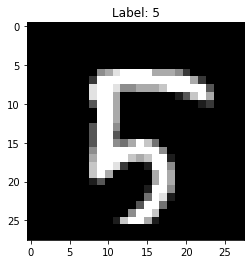

In [6]:
idx = np.random.choice(range(num_train_images))

image = train_dataset[idx][0]
label = train_dataset[idx][1]

plt.imshow(np.squeeze(image.numpy()), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

### Dataloader

El DataLoader es una herramienta importante para preparar, gestionar y servir los datos a las redes de aprendizaje profundo. 

In [7]:
batch_size = 100
num_epochs = 100
run_dry = False # Si True solamente utiliza una pequeña parte del conjunto de datos.

if run_dry:
    train_sampler = SubsetRandomSampler(range(len(train_dataset))[:batch_size * 2])
    val_sampler = SubsetRandomSampler(range(len(val_dataset))[:batch_size * 2])
    test_sampler = SubsetRandomSampler(range(len(test_dataset))[:batch_size * 2])
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size, 
                                              sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                             batch_size=batch_size, 
                                             shuffle=False, 
                                             sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False, 
                                              sampler=test_sampler)
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size, 
                                               shuffle=True) 
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size, 
                                             shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False)

### Visualización de ejemplos aleatorios de un batch

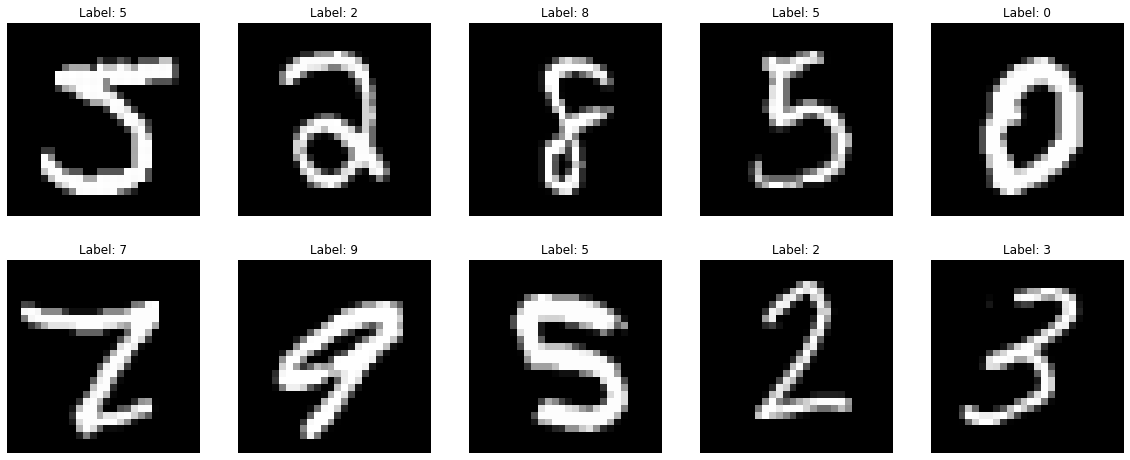

In [8]:
num_samples = 10
rand_samples = np.random.choice(batch_size, num_samples)

batch = next(iter(train_loader))
images, labels = batch

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    image = np.squeeze(images[i].numpy())
    label = labels[i]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
    ax.imshow(image, cmap='gray')
plt.show()

### Modelo

In [9]:
class ConvNetModel(nn.Module):
    def __init__(self):
        super(ConvNetModel, self).__init__()
        # Convolución 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, 
                               stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # Max Pooling 1
        self.mp1 = nn.MaxPool2d(kernel_size=2) 

        # Convolución 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                               stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Max Pooling 2
        self.mp2 = nn.MaxPool2d(kernel_size=2)

        # Lineal
        self.fc1 = nn.Linear(32 * 7 * 7, 10)  

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.mp1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.mp2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

Intanciación del modelo

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Forma de cálculo: {device}')

set_all_seeds()

Forma de cálculo: cuda:0


In [11]:
output_dim = 10 # 10 Dígitos

model = ConvNetModel().to(device)

# Descripción del modelo
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNetModel                             [100, 10]                 --
├─Conv2d: 1-1                            [100, 16, 28, 28]         160
├─ReLU: 1-2                              [100, 16, 28, 28]         --
├─MaxPool2d: 1-3                         [100, 16, 14, 14]         --
├─Conv2d: 1-4                            [100, 32, 14, 14]         4,640
├─ReLU: 1-5                              [100, 32, 14, 14]         --
├─MaxPool2d: 1-6                         [100, 32, 7, 7]           --
├─Linear: 1-7                            [100, 10]                 15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
Total mult-adds (M): 105.06
Input size (MB): 0.31
Forward/backward pass size (MB): 15.06
Params size (MB): 0.08
Estimated Total Size (MB): 15.46

Función de coste

In [15]:
criterion = nn.CrossEntropyLoss()

### Optimizador

In [16]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

### Entrenamiento del modelo

In [17]:
# Info
print(f'Number of epochs: {num_epochs}')
print(f'Batch size: {batch_size}')

Number of epochs: 100
Batch size: 100


In [18]:
losses_train = []
losses_val = []
n_iter = 0

best_val_loss = np.inf
patience = 10
trigger_times = 0

for epoch in tqdm(range(num_epochs)):
    n_iter = n_iter + 1
    model.train() # Establecer el modo entrenamiento

    # for loop going through dataset
    running_train_loss = 0

    for i, data in enumerate(train_loader):
        x = data[0].to(device)
        y = data[1].to(device)

        # Borrar los gradientes con respecto a los parámetros
        optimizer.zero_grad()

        # inferencia
        y_hat = model(x)

        # función de coste
        loss = criterion(y_hat, y)

        running_train_loss += loss.item()

        # backward
        loss.backward()
        optimizer.step()
    
    losses_train.append(running_train_loss / len(train_loader))
    
    model.eval()  # Modo evaluation

    ###### Test
    running_val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            # data preparation
            x = data[0].to(device)
            y = data[1].to(device)

            y_hat = model(x)

            # función de coste en el conjunto de test
            loss = criterion(y_hat, y)

            running_val_loss += loss.item()

        losses_val.append(running_val_loss / len(val_loader))
        
        # Early stopping
        if running_val_loss >= best_val_loss:
            trigger_times = trigger_times + 1
            if trigger_times >= patience:
              break
        elif running_val_loss < best_val_loss:
            best_val_loss = running_val_loss
            torch.save(model.state_dict(), './model.cpkt') # Guardar modelo
                

 19%|█▉        | 19/100 [02:05<08:56,  6.62s/it]


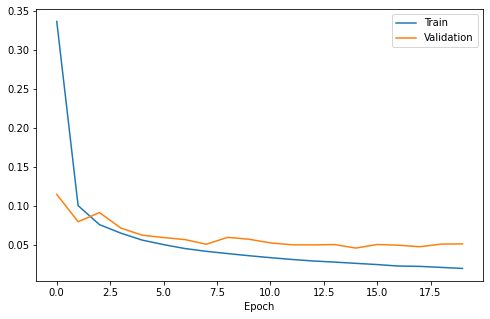

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(losses_train, label='Train')
plt.plot(losses_val, label='Validation')
plt.xlabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Cargar el modelo entrenado

In [20]:
model.load_state_dict(torch.load('./model.cpkt'))
model = model.to(device)

### Evaluación del modelo

In [21]:
y_actual = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        x = data[0].to(device)
        y = data[1].to(device)

        out = model(x)
        _, y_hat = torch.max(out, 1)

        y_actual = y_actual + list(y.detach().cpu().numpy())
        y_pred = y_pred + list(y_hat.detach().cpu().numpy())

In [22]:
print(classification_report(y_actual, y_pred, target_names=list(np.unique(y_actual).astype(str))))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.97      0.98       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



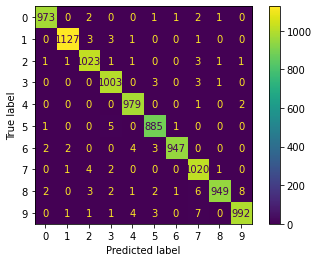

In [23]:
cm = confusion_matrix(y_actual, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()